Question to be answered: Using ESOL dataset, predict experimental solubility using the following five features listed in the dataset: Molecular Weight, Number of H-Bond Donors, Number of Rings, Number of Rotatable Bonds, Polar Surface Area. 

## Setup


In [1]:
## Setup

# import 
import sys
import sklearn
import sklearn.linear_model


import numpy as np
import os
import pandas as pd
import scipy.stats as stats

# to make notebook's output stable across runs
np.random.seed(42)

# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

In [2]:
## Get the data
datapath = os.path.join("datasets", "molecsol", "")
os.makedirs(datapath, exist_ok=True)

import urllib
DOWNLOAD_ROOT="https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/"
filename = "delaney-processed.csv"
url = DOWNLOAD_ROOT + filename
urllib.request.urlretrieve(url, datapath + filename)

('datasets/molecsol/delaney-processed.csv',
 <http.client.HTTPMessage at 0x7f8319c407d0>)

## Import Data

In [3]:
ESOL = pd.read_csv(datapath + filename, thousands=',')
ESOL.head(5)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [4]:
#We need: 
#Molecular Weight, Number of H-Bond Donors, Number of Rings, Number of Rotatable Bonds, Polar Surface Area.

#So we need to drop: Compound ID, ESOL predicted... , minimum degree, and measured log solubility...

column_labels = list(ESOL.columns.values)

In [5]:

ESOL = ESOL.drop(column_labels[-1:], axis = 1)
ESOL = ESOL.drop(column_labels[:3], axis = 1)

In [6]:
ESOL.head(5)

#This is our dataset.

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
0,457.432,7,3,7,202.32,-0.77
1,201.225,1,2,2,42.24,-3.30
2,152.237,0,0,4,17.07,-2.06
3,278.354,0,5,0,0.00,-7.87
4,84.143,0,1,0,0.00,-1.33


## Visualize Data

<function matplotlib.pyplot.show(*args, **kw)>

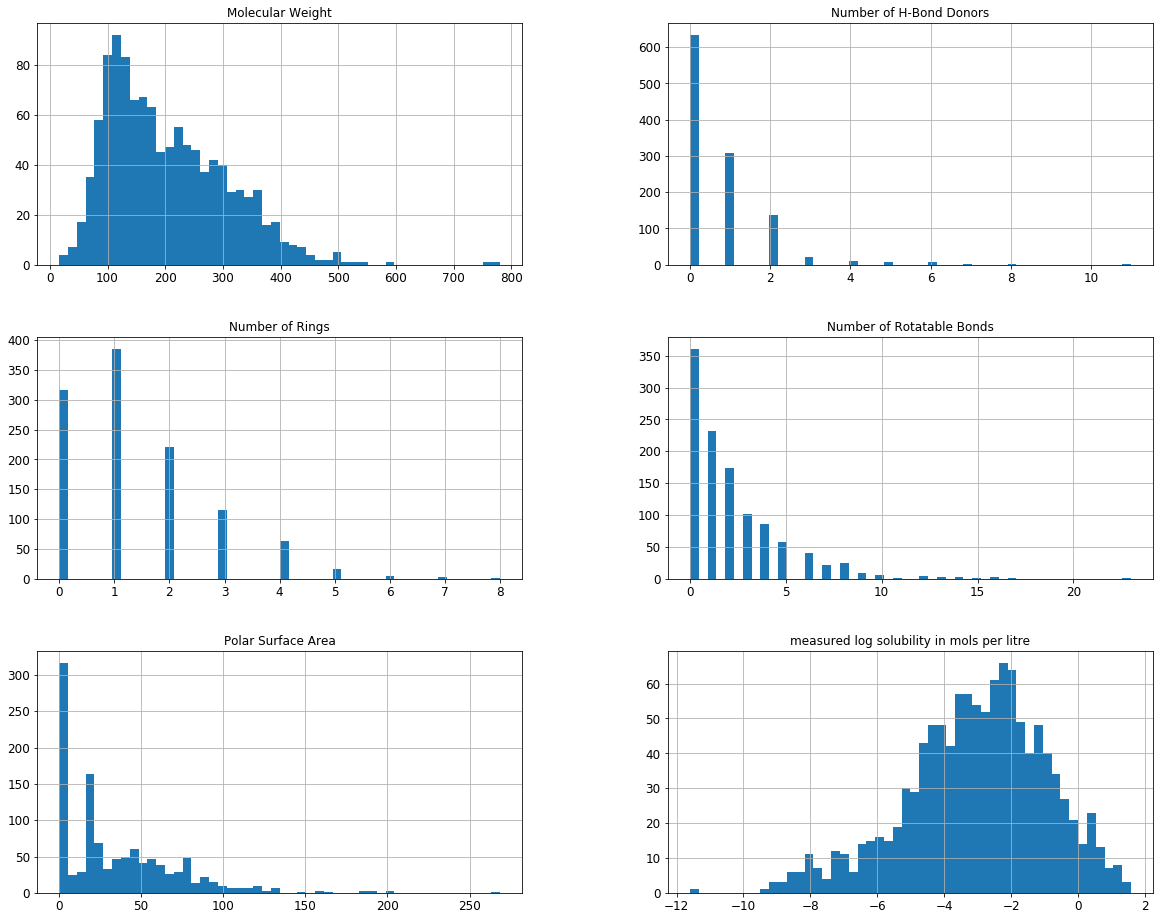

In [7]:
#Visualize the current data
ESOL.hist(bins = 50, figsize = (20,16))
plt.show

#We observe tailing. features are comperable in magnitude
#We should striate the test set.

In [8]:
#Check data for cleaning
ESOL.info

#data looks strictly numerical, none categorical

<bound method DataFrame.info of       Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0              457.432                        7                3   
1              201.225                        1                2   
2              152.237                        0                0   
3              278.354                        0                5   
4               84.143                        0                1   
...                ...                      ...              ...   
1123           197.381                        0                0   
1124           219.266                        1                0   
1125           246.359                        0                0   
1126            72.151                        0                0   
1127           365.964                        0                1   

      Number of Rotatable Bonds  Polar Surface Area  \
0                             7              202.32   
1                             2          

In [9]:
ESOL.describe()
#counts are all the same, no data missing.

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


## Prepare Training Data

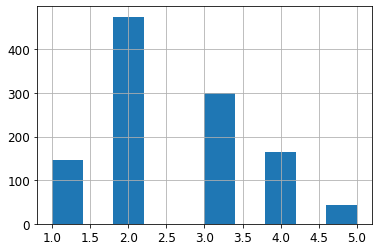

In [10]:
## Create the test set. We will use striation and shuffle. The MW seems to be indirectly proportional to the labels, so we will use MW
ESOL["MW_bins"] = pd.cut(ESOL["Molecular Weight"],
                        bins=[0., 100., 200., 300., 400., np.inf],
                        labels=[1, 2, 3, 4, 5])

ESOL["MW_bins"].hist()


from sklearn.model_selection import StratifiedShuffleSplit
#This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds.
#The folds are made by preserving the percentage of samples for each class

SSS = StratifiedShuffleSplit(test_size=0.2, random_state=42)
for train_index, test_index in SSS.split(ESOL, ESOL["MW_bins"]):    
    strat_train_set = ESOL.loc[train_index]    
    strat_test_set = ESOL.loc[test_index]

In [11]:
strat_test_set["MW_bins"].value_counts() / len(strat_test_set)

2    0.420354
3    0.265487
4    0.146018
1    0.128319
5    0.039823
Name: MW_bins, dtype: float64

In [12]:
#We no longer need the bin label, so we will drop it.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("MW_bins", axis=1, inplace=True)

In [13]:
#Observe correlations in the features to the label:

correlation = strat_train_set.corr()
correlation["measured log solubility in mols per litre"].sort_values(ascending=False)

#We note that the Moleculear weight is mostly strongly (negatively) correlated to the label.

measured log solubility in mols per litre    1.000000
Number of H-Bond Donors                      0.203955
Polar Surface Area                           0.127014
Number of Rotatable Bonds                   -0.249166
Number of Rings                             -0.500843
Molecular Weight                            -0.630387
Name: measured log solubility in mols per litre, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f831a2fe090>,
      dtype=object)

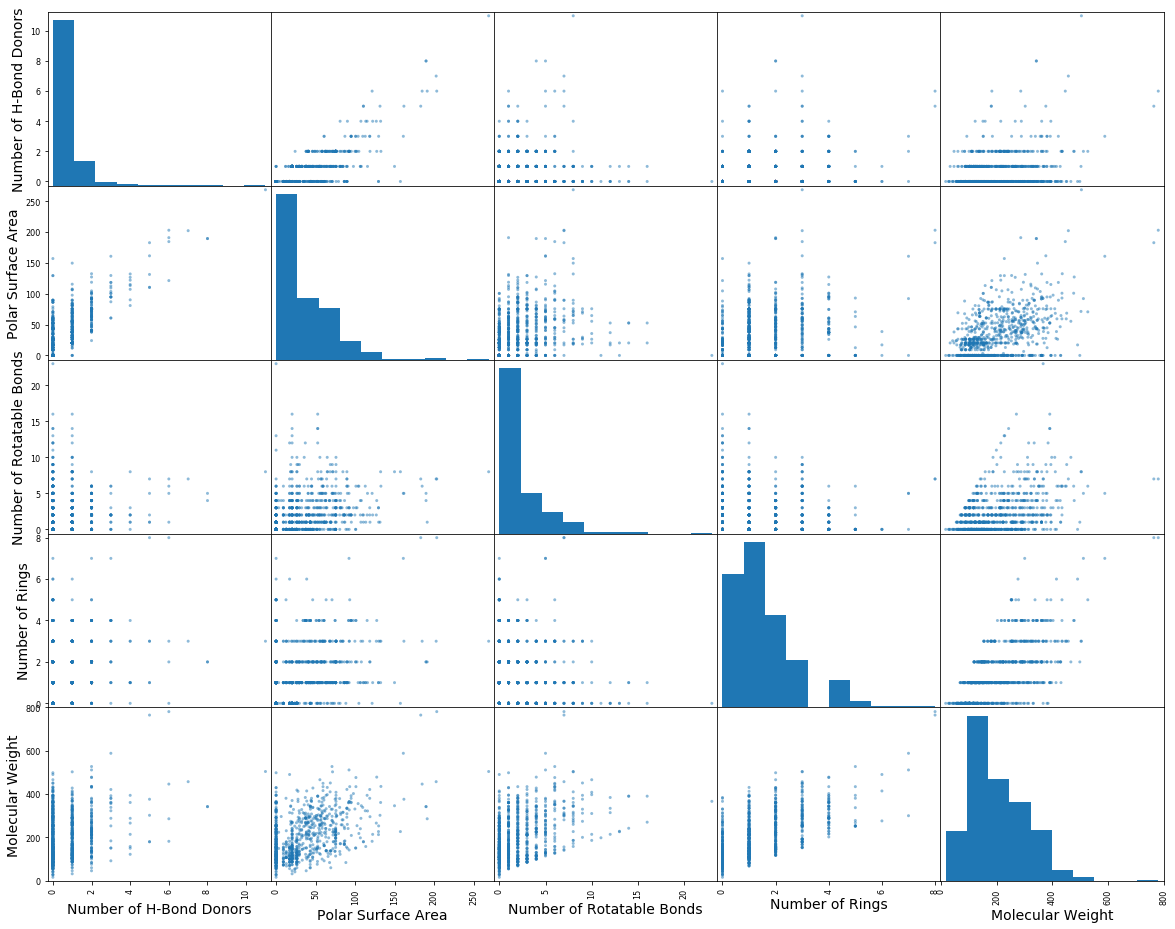

In [14]:
#Visualize correlation to see if we can add any new features.
from pandas.plotting import scatter_matrix

attributes = ["Number of H-Bond Donors", "Polar Surface Area", "Number of Rotatable Bonds",
              "Number of Rings", "Molecular Weight"]
scatter_matrix(strat_train_set[attributes], figsize=(20, 16))

In [15]:
strat_train_set.head(5)

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
518,293.348,1,2,3,89.43,-3.590
1000,74.079,0,0,2,26.30,0.150
203,298.304,0,1,7,63.84,-4.862
514,223.228,1,2,2,56.79,-1.570
84,134.222,0,1,2,0.00,-3.280


In [16]:
#Preprocess the features

ESOL_train_labels = strat_train_set["measured log solubility in mols per litre"].copy()
ESOL_train_features = strat_train_set.drop("measured log solubility in mols per litre", axis=1)


#only standardization needed, no other imputers or attribute modifications.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

ESOL_preprocessed = num_pipeline.fit_transform(ESOL_train_features)


In [17]:
ESOL_train_features.describe()

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
count,902.000000,902.000000,902.000000,902.000000,902.000000
mean,203.849924,0.692905,1.390244,2.187361,34.820310
std,103.818288,1.098851,1.328687,2.673364,36.051941
min,16.043000,0.000000,0.000000,0.000000,0.000000
25%,120.195000,0.000000,0.000000,0.000000,0.000000
50%,182.145500,0.000000,1.000000,1.000000,26.300000
75%,270.468750,1.000000,2.000000,3.000000,55.395000
max,780.949000,11.000000,8.000000,23.000000,268.680000


In [18]:
ESOL_train_labels.describe()

count    902.000000
mean      -3.058846
std        2.112443
min      -11.600000
25%       -4.300000
50%       -2.884000
75%       -1.600000
max        1.580000
Name: measured log solubility in mols per litre, dtype: float64

## Train Models
* For this homework, we will try linear regression and random forests, and compare the two results.


In [19]:
def plot_prediction(predictions, labels):
    plt.scatter(predictions, labels)
    plt.xlabel("predictions")
    plt.ylabel("Labels")

### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(ESOL_preprocessed, ESOL_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
some_data = ESOL_train_features.iloc[:5]
some_labels = ESOL_train_labels.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [-2.82743044 -1.0111761  -3.97021761 -2.81473366 -3.12784727]
Labels: [-3.59, 0.15, -4.862, -1.57, -3.28]


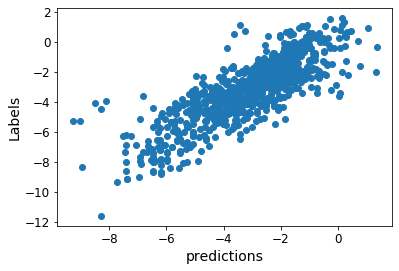

In [22]:
plot_prediction(lin_reg.predict(ESOL_preprocessed), ESOL_train_labels)

In [23]:
from sklearn.metrics import mean_squared_error

ESOL_predictions = lin_reg.predict(ESOL_preprocessed)
lin_mse = mean_squared_error(ESOL_train_labels, ESOL_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.1902245867192507

In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, ESOL_preprocessed, ESOL_train_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [25]:
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores: [1.29133445 1.25375177 1.13277594 1.40690887 0.96572693 1.10911632
 1.26702529 1.10831824 1.21173491 1.22639924]
Mean: 1.1973091957626611
Standard deviation: 0.11634666454478586


* scores for the CV set and training set are similar. training error is similar to the generalization error. Likely underfitting, we need a more complex model.

### Random Forest 

In [26]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(ESOL_preprocessed, ESOL_train_labels)

forest_scores = cross_val_score(forest_reg, ESOL_preprocessed, ESOL_train_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

/Users/vernie/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


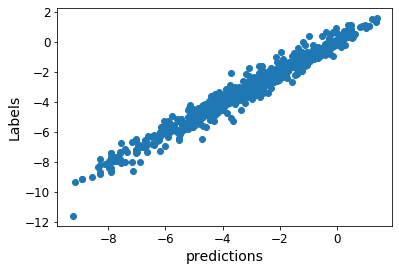

In [27]:
plot_prediction(forest_reg.predict(ESOL_preprocessed), ESOL_train_labels)

In [28]:
forest_predictions = forest_reg.predict(ESOL_preprocessed)
forest_mse = mean_squared_error(ESOL_train_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.37552305701472466

In [29]:
display_scores(forest_rmse_scores)

Scores: [0.90044434 1.04783673 0.89389878 1.08595366 0.65206459 0.85165349
 0.85491937 0.70963808 0.86843191 0.87730647]
Mean: 0.8742147416039139
Standard deviation: 0.12386036899934726


* scores for the CV set and training set are not similar, validation > training error. Likely overfitting.

## Improving the Random Forest Model

In [30]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': stats.randint(1, 50), 
              'max_features': stats.randint(1, 5)}

forest_reg = RandomForestRegressor()

random_search = RandomizedSearchCV(forest_reg, param_dist, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_iter=20)

random_search.fit(ESOL_preprocessed, ESOL_train_labels)

/Users/vernie/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [31]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=45,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
cv_results = random_search.cv_results_
>>> for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
...     print(np.sqrt(-mean_score), params)

0.9025113201365472 {'max_features': 4, 'n_estimators': 15}
0.9134645251021897 {'max_features': 4, 'n_estimators': 14}
0.8778363991042726 {'max_features': 3, 'n_estimators': 40}
0.9041860585723138 {'max_features': 1, 'n_estimators': 16}
0.9015073785543668 {'max_features': 1, 'n_estimators': 18}
0.8810213608217687 {'max_features': 3, 'n_estimators': 24}
0.8930206561063964 {'max_features': 2, 'n_estimators': 25}
0.8862507103935198 {'max_features': 4, 'n_estimators': 45}
0.8888220478502981 {'max_features': 1, 'n_estimators': 29}
0.8600004628798743 {'max_features': 3, 'n_estimators': 45}
0.9001531407132308 {'max_features': 1, 'n_estimators': 25}
0.9098487955050352 {'max_features': 3, 'n_estimators': 9}
1.2121042290236987 {'max_features': 4, 'n_estimators': 1}
0.9390978185957367 {'max_features': 4, 'n_estimators': 8}
0.9141009552280288 {'max_features': 4, 'n_estimators': 11}
0.911117102223833 {'max_features': 3, 'n_estimators': 17}
0.8916968089226776 {'max_features': 4, 'n_estimators': 35}
0

### Deploy model on test set.

In [33]:
final_model = random_search.best_estimator_

X_test = strat_test_set.drop("measured log solubility in mols per litre", axis=1)
y_test = strat_test_set["measured log solubility in mols per litre"].copy()

X_test_prepared = num_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_model_mse = mean_squared_error(y_test, final_predictions)
final_model_rmse = np.sqrt(final_model_mse)
print(final_model_rmse)

0.8161219662805076


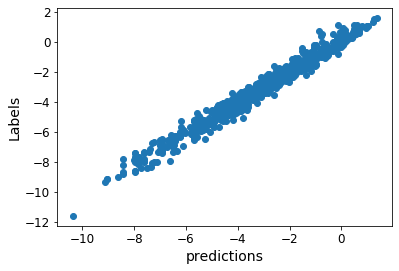

In [34]:
plot_prediction(final_model.predict(ESOL_preprocessed), ESOL_train_labels)

In [35]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([0.7014726 , 0.91654041])

## Observe which features were ultimately important

In [36]:
feature_importances = random_search.best_estimator_.feature_importances_
feature_importances

array([0.50186248, 0.04780796, 0.1398716 , 0.0831827 , 0.22727525])

In [37]:
attributes = list(ESOL_train_features)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.5018624839418289, 'Molecular Weight'),
 (0.22727524939279803, 'Polar Surface Area'),
 (0.13987160090259218, 'Number of Rings'),
 (0.08318270386728308, 'Number of Rotatable Bonds'),
 (0.04780796189549777, 'Number of H-Bond Donors')]